In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVC
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.decomposition import PCA

In [2]:
train=pd.read_csv(r'e:\data\benz_train.csv')
test=pd.read_csv(r'e:\data\benz_test.csv')

In [3]:
print(train.shape)
print(train.info())
train.head(3)

(4209, 378)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0


共有4209行，378列。
y为float类
x0-x8为int64类
剩余的为obj类

### 分析目标特征y

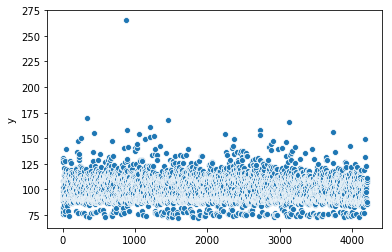

In [4]:
sns.scatterplot(train.index,train['y'])

大部分值聚集在75-175之间，但存在一个离群值，在这里简单的把它丢弃。

In [5]:
train.drop(train[train['y']>175].index,inplace=True,axis=0)

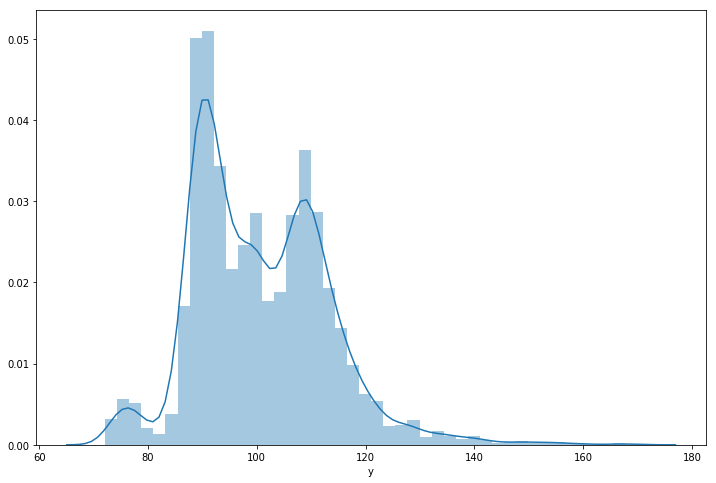

In [6]:
fig=plt.figure(figsize=(12,8))
sns.distplot(train['y'])

### 数值列分析

In [7]:
zero_val=[]
for col in train.columns:
    if train[col].dtype=='int64' and train[col].unique().any()==0:
        zero_val.append(col)
print(zero_val)

['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


通过分析，找出其中值为全0的列。

### 分类列分析

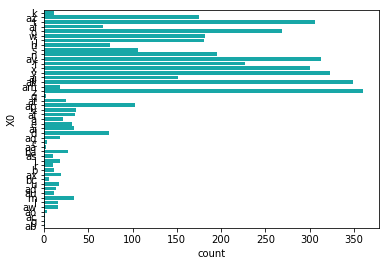

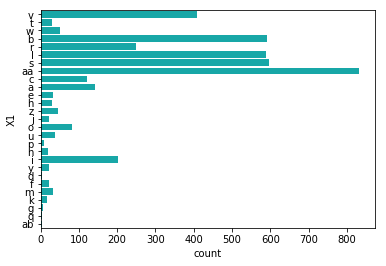

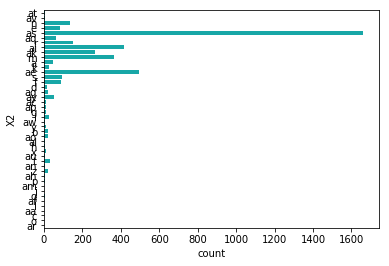

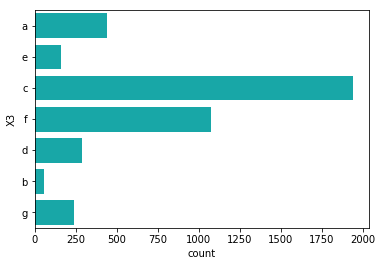

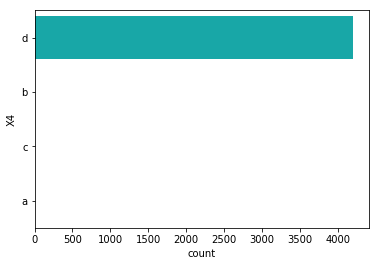

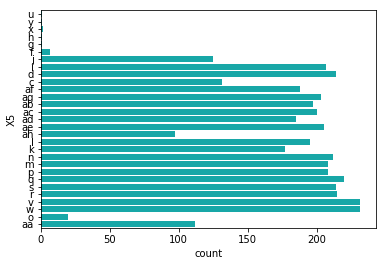

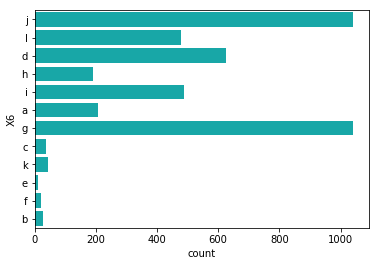

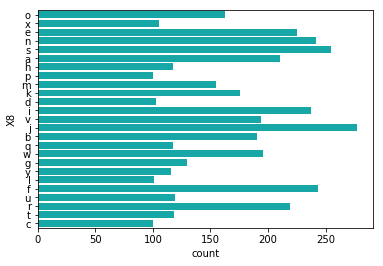

In [8]:
for col in train.columns:
    if train[col].dtype=='object':
        fig=plt.figure()
        sns.countplot(y=train[col],color='c')

可以看出X4列只有单一数值d，如果x4是训练特征集的一部分，可能会影响最后的建模。

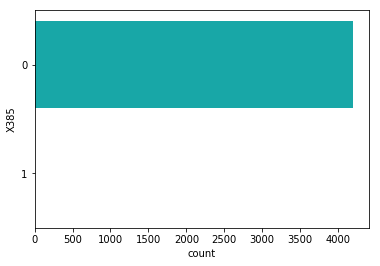

In [9]:
sns.countplot(y=test[col],color='c')

在测试数据中，X4同样只有单项数值d,所以在训练集和测试集中都将X4列删除。

In [10]:
train.drop('X4',inplace=True,axis=1)
test.drop('X4',inplace=True,axis=1)

将分类特征转换为数字便于建模

In [11]:
ret_train_df=pd.get_dummies(train,columns=['X0', 'X1', 'X2','X3','X5','X6','X8'],
                           prefix=['X0', 'X1', 'X2','X3','X5','X6','X8'])
ret_test_df = pd.get_dummies(test, columns=['X0', 'X1', 'X2','X3','X5','X6','X8'], 
                             prefix=['X0', 'X1', 'X2','X3','X5','X6','X8'])

In [12]:
ret_train_df

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,130.81,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,88.53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,76.26,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,9,80.62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,18,92.93,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,24,128.76,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,25,91.91,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,27,108.67,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,30,126.99,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
len(train.columns)

377

In [27]:
train_X = ret_train_df.drop(['ID','y'], axis=1)
train_Y = ret_train_df['y'].values
test_X = ret_test_df.drop(['ID'],axis=1)
#同步训练和测试数据
matching_cols = train_X.columns.intersection(test_X.columns)
train_X=train_X[matching_cols]
test_X=test_X[matching_cols]
train_x,test_x,train_y,test_y = train_test_split(train_X, train_Y, test_size=0.33, random_state=42)

In [28]:
def linear_regression(train_x,train_y,test_x,test_y):
    lr=LinearRegression()
    lr.fit(train_x,train_y)
    pred=lr.predict(test_x)
    score=round(r2_score(test_y,pred),2)
    return {'model':'LinearRegressor', 'r2_score':score}

In [29]:
def random_forest_regressor(train_x,train_y,test_x,test_y):
    rfr=RandomForestRegressor()
    rfr.fit(train_x,train_y)
    pred=rfr.predict(test_x)
    score=round(r2_score(test_y,pred),2)
    return {'model':'random_forest_regressor', 'r2_score':score}

In [30]:
def linear_lasso(train_x,train_y,test_x,test_y):
    ll=Lasso(alpha=1.0)
    ll.fit(train_x,train_y)
    pred=ll.predict(test_x)
    score=round(r2_score(test_y,pred),2)
    return {'model':'linear_lasso', 'r2_score':score}

In [31]:
def svr(train_x, train_y, test_x, test_y):
    s=SVR()
    s.fit(train_x,train_y)
    pred=s.predict(test_x)
    score=round(r2_score(test_y,pred),2)
    return{'model':'svr','r2_score':score}

In [32]:
pca=PCA(n_components = 10,svd_solver='randomized',whiten=True)
pca.fit(train_x)
pca_train_x=pca.transform(train_x)
pca_test_x=pca.transform(test_x)
print(linear_regression(pca_train_x,train_y,pca_test_x,test_y))
print(random_forest_regressor(pca_train_x,train_y,pca_test_x,test_y))
print(linear_lasso(pca_train_x,train_y,pca_test_x,test_y))
print(svr(pca_train_x,train_y,pca_test_x,test_y))

{'model': 'LinearRegressor', 'r2_score': 0.45}
{'model': 'random_forest_regressor', 'r2_score': 0.43}
{'model': 'linear_lasso', 'r2_score': 0.4}
{'model': 'svr', 'r2_score': 0.47}


最终选择svr算法

In [43]:
pca=PCA(n_components = 10,svd_solver='randomized',whiten=True)
pca.fit(train_X)
pca_train_X=pca.transform(train_X.values)
pca_test_X=pca.transform(test_X.values)
clf=SVR()
clf.fit(pca_train_X,train_Y)
pred=clf.predict(pca_test_X)


In [69]:
test['y']=pred
final=test.loc[:,['ID','y']]
final.to_csv('e:\\data\\benz.csv',index=False)